In [15]:
"""
CLAB Task-1: Harris Corner Detector
Your name (Your uniID):u6541559
"""

import numpy as np

In [16]:
def conv2(img, conv_filter):
    # flip the filter
    f_siz_1, f_size_2 = conv_filter.shape
    conv_filter = conv_filter[range(f_siz_1 - 1, -1, -1), :][:, range(f_siz_1 - 1, -1, -1)]
    pad = (conv_filter.shape[0] - 1) // 2
    result = np.zeros((img.shape))
    img = np.pad(img, ((pad, pad), (pad, pad)), 'constant', constant_values=(0, 0))
    filter_size = conv_filter.shape[0]
    for r in np.arange(img.shape[0] - filter_size + 1):
        for c in np.arange(img.shape[1] - filter_size + 1):
            curr_region = img[r:r + filter_size, c:c + filter_size]
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result)  # Summing the result of multiplication.
            result[r, c] = conv_sum  # Saving the summation in the convolution layer feature map.

    return result

In [17]:

def fspecial(shape=(3, 3), sigma=0.5):
    m, n = [(ss - 1.) / 2. for ss in shape]
    y, x = np.ogrid[-m:m + 1, -n:n + 1]
    h = np.exp(-(x * x + y * y) / (2. * sigma * sigma))
    h[h < np.finfo(h.dtype).eps * h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h


In [18]:
# Parameters, add more if needed
sigma = 2
thresh = 0.01
#range of k should be 0.01- 0.1
k = 0.05  

# Derivative masks
dx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
dy = dx.transpose()
import matplotlib.pyplot as plt
bw = plt.imread('Harris-2.jpg')
bw = np.array(bw * 255, dtype=int)
# computer x and y derivatives of image
Ix = conv2(bw, dx)
Iy = conv2(bw, dy)

In [19]:
# Set up a gaussian kernel with shape of no less than 1*1, the shape is also dependent on the sigma size 
g = fspecial((max(1, np.floor(3 * sigma) * 2 + 1), max(1, np.floor(3 * sigma) * 2 + 1)), sigma)


In [20]:
Iy2 = conv2(np.power(Iy, 2), g)
Ix2 = conv2(np.power(Ix, 2), g)
Ixy = conv2(Ix * Iy, g)

In [21]:
######################################################################
# Task: Compute the Harris Cornerness
######################################################################

def get_Harris_Cornerness(kernel_size,Ix2,Iy2,Ixy,k):
    ''' Compute the Harris Cornerness using the determinnet formula, and eignvalues 
    '''
    kernel = np.ones((kernel_size,kernel_size))# weight vector of 2-d array with all ones for computing the sum later
    lambda_1 = conv2(Ix2, kernel) # Compute the sum of the IX2 in the neighbourhood area (localized 1st eigenvalue)
    lambda_2 = conv2(Iy2, kernel) # Compute the sum of the Iy2 in the neighbourhood area (localized 2nd eigenvalue)
    squared_sum_Ixy =  np.square(conv2(Ixy, kernel)) # anti-diagnal product for calculation of determinent later 

    det = lambda_1 * lambda_2 - squared_sum_Ixy # determinent of matrix M
    trace = lambda_1 + lambda_2 # trace of matrix M
    R = det - (k * trace**2) # Harris Cornerness
    return R  


In [22]:
R = get_Harris_Cornerness(5,Ix2,Iy2,Ixy,k)

In [23]:
######################################################################
# Task: Perform non-maximum suppression and
#       thresholding, return the N corner points
#       as an Nx2 matrix of x and y coordinates
######################################################################
def non_maximum_suppression(R):
    ''' Given the R value of the location in the picture and obtain the location of picture which is 8-way local maxima
        and also passes the trheshold 
    '''
    corner_list = []
    # get the maximum R value and compute the thresh propotion of the maximum R,get real threshold the R value need to reach 
    threshold = R.flatten().max()*thresh  
    row,col = R.shape
    for i in range(1, row-1):
        for j in range(1, col-1):
            # Select corners that are 8-way local maxima 
            if ( (R[i,j] >=R[i-1,j]) & (R[i,j] >= R[i,j+1]) &  (R[i,j] >= R[i+1,j]) &(R[i,j] >= R[i+1,j+1]) & (R[i,j] >= R[i-1,j-1]) & 
                (R[i,j] >= R[i-1,j+1]) & (R[i,j] >= R[i,j-1]) &(R[i,j] >= R[i-1,j-1])):  
                    # Double check the corner has passed the threshold 
                    if R[i,j] >= threshold:
                        corner_list.append([i, j]) # record the selceted corner 
    return corner_list

corners = non_maximum_suppression(R)

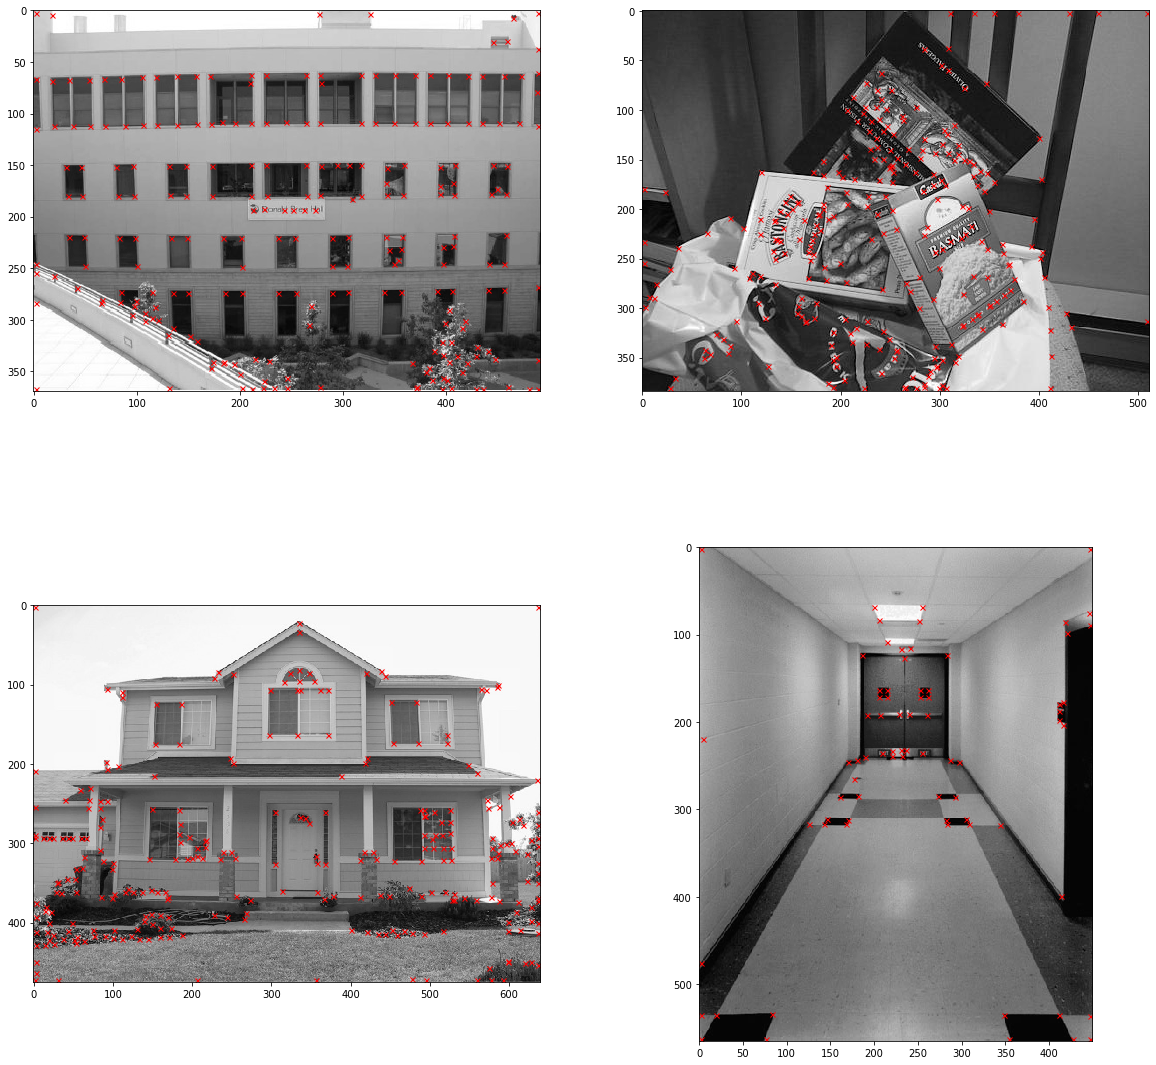

In [25]:
import cv2
plt.figure(figsize=(20, 20))
plt.title('compuatational result')
number1 = []
# Loop over each of the testing pictures 
for i in range(1,5):
    path = 'Harris-'+str(i)+'.jpg' 
    bw = plt.imread(path)
    if len(bw.shape) == 3: # For colourful image, turn it to gray scale 
        bw = cv2.cvtColor(bw, cv2.COLOR_RGB2GRAY)
    Ix = conv2(bw, dx)
    Iy = conv2(bw, dy)
    Iy2 = conv2(np.power(Iy, 2), g)
    Ix2 = conv2(np.power(Ix, 2), g)
    Ixy = conv2(Ix * Iy, g)
    R = get_Harris_Cornerness(5,Ix2,Iy2,Ixy,k)
    corner_list = non_maximum_suppression(R)
    number1.append(len(corner_list))
    plt.subplot(2, 2, i)
    plt.imshow(bw, cmap='gray')
    plt.plot([c[1] for c in corner_list], [c[0] for c in corner_list], '.r', markersize=5, marker='x')

In [26]:
number1

[235, 271, 285, 75]

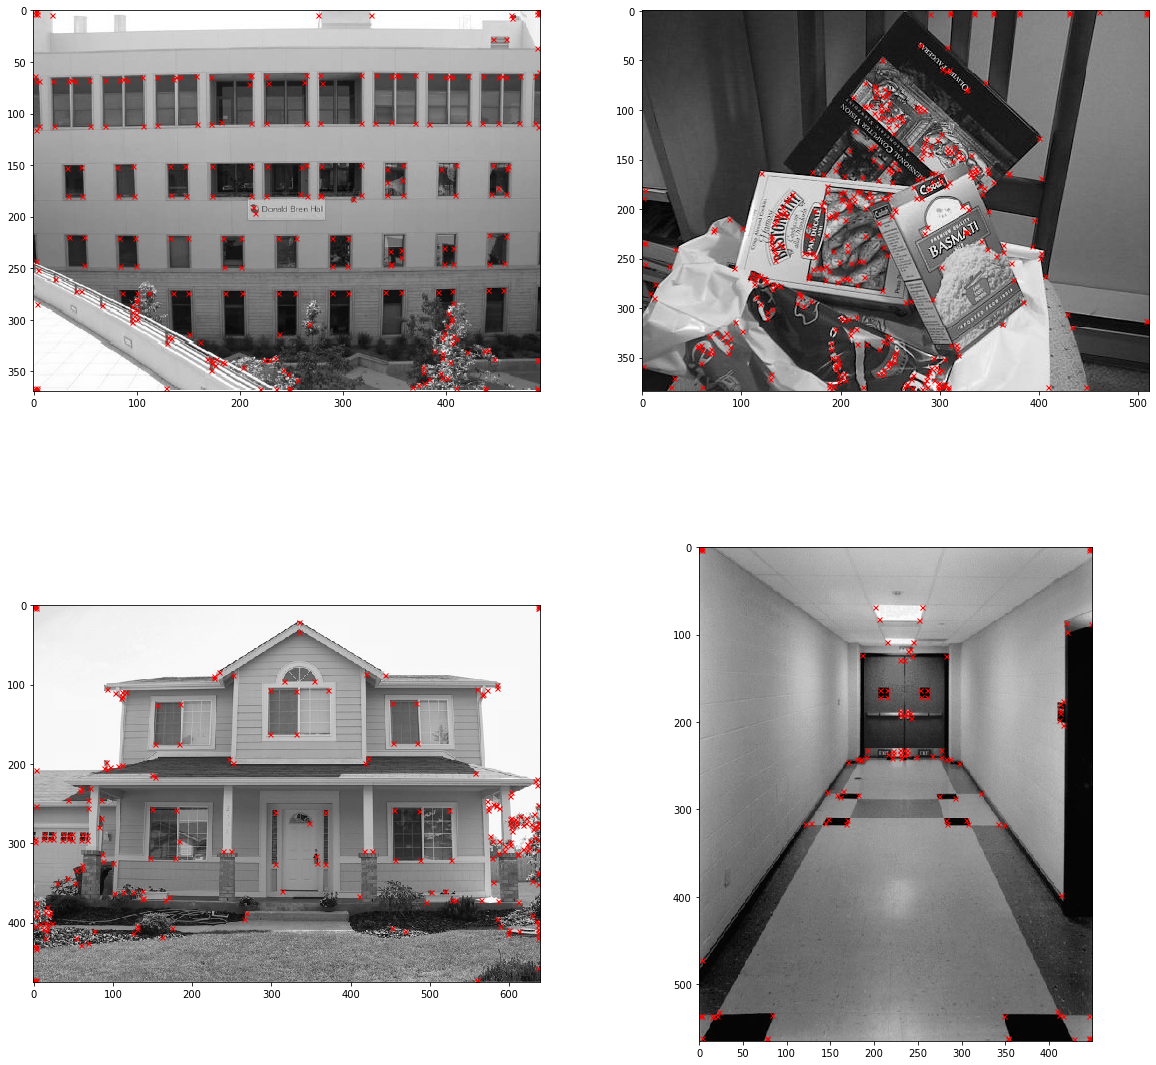

In [12]:
plt.figure(figsize=(20, 20))
plt.title('built in result')
# Compare with built-in function 
number2 = []
# Loop over each of the testing pictures 
for i in range(1,5):
    path = 'Harris-'+str(i)+'.jpg'
    bw = plt.imread(path)
    if len(bw.shape) == 3: # For colourful image, turn it to gray scale 
        bw = cv2.cvtColor(bw, cv2.COLOR_RGB2GRAY)
    Ix = conv2(bw, dx)
    Iy = conv2(bw, dy)
    Iy2 = conv2(np.power(Iy, 2), g)
    Ix2 = conv2(np.power(Ix, 2), g)
    Ixy = conv2(Ix * Iy, g)
    R = cv2.cornerHarris(conv2(bw, g).astype(np.float32), 5, 3, k)
    corners = non_maximum_suppression(R)
    number2.append(len(corners))
    plt.subplot(2, 2, i)
    plt.imshow(bw, cmap='gray')
    plt.plot([c[1] for c in corners], [c[0] for c in corners], '.r', markersize=5, marker='x')

In [27]:
number2

[263, 384, 242, 113]